In [2]:
import numpy as np

import torch
from torchvision import transforms

import beacon

from torchinfo import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import Generator3D

In [2]:
data = torch.zeros(90, 100)
pr, pl = Generator3D.draw_parabola(data)

angle = np.random.randint(10, 40)
Generator3D.draw_line(data, pr, angle)
Generator3D.draw_line(data, pl, angle)
Generator3D.random_remove_points(data, 0.9)

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [4]:
train_data = Generator3D.generate(300, 120, 92, 32, n_points=0)
test_data = Generator3D.generate(300, 120, 92, 1, n_points=0)

train_data_noisy = Generator3D.add_noise(train_data, p=0.0001)
test_data_noisy = Generator3D.add_noise(test_data, p=0.0001)

In [5]:
train_data.shape   # (batch size, features, t, x, y)

torch.Size([32, 1, 300, 120, 92])

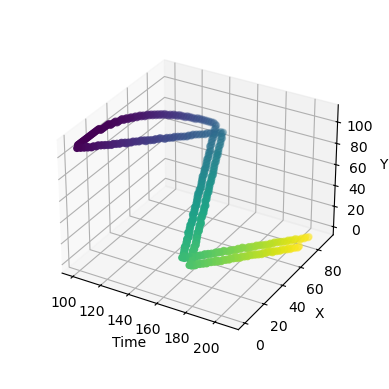

In [9]:
Generator3D.plot(train_data[0, 0])

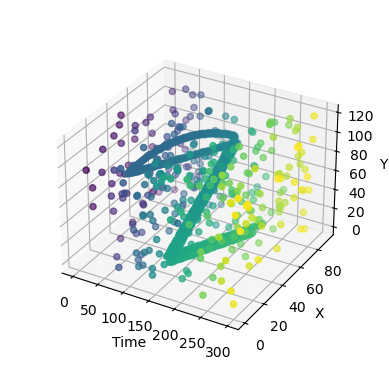

In [10]:
Generator3D.plot(train_data_noisy[0, 0])

In [11]:
class ConvolutionAutoencoder(beacon.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv3d(1, 64, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.Conv3d(64, 16, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.Conv3d(16, 8, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(8),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )
        
        self.decoder = torch.nn.Sequential(
            #torch.nn.Unflatten(1, (8, 300, 120, 92)),
            torch.nn.ConvTranspose3d(8, 16, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose3d(16, 64, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose3d(64, 1, kernel_size=4, stride=1, padding=0),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
d = torch.randn(1, 1, 300, 120, 92)
encoder = torch.nn.Sequential(
            torch.nn.Conv3d(1, 64, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.Conv3d(64, 16, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.Conv3d(16, 8, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(8),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )
e = encoder(d)
print(e.shape)

decoder = torch.nn.Sequential(
            #torch.nn.Unflatten(1, (8, 300, 120, 92)),
            torch.nn.ConvTranspose3d(8, 16, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose3d(16, 64, kernel_size=4, stride=1, padding=0),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose3d(64, 1, kernel_size=4, stride=1, padding=0),
            torch.nn.Sigmoid()
        )

decoder(e).shape

torch.Size([1, 8, 291, 111, 83])


torch.Size([1, 1, 300, 120, 92])

In [99]:
d.shape

torch.Size([1, 1, 300, 120, 92])

In [78]:
m = torch.nn.Sequential(
    torch.nn.Linear(50, 50),
    torch.nn.Unflatten(1, (2, -1))
)
a = torch.randn(2, 50)
o = m(a)
o.shape

torch.Size([2, 2, 25])

In [13]:
summary(ConvolutionAutoencoder(), input_size=(1, 1, 300, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [1, 1, 300, 120, 92]      --
├─Sequential: 1-1                        [1, 8, 291, 111, 83]      --
│    └─Conv3d: 2-1                       [1, 64, 297, 117, 89]     4,160
│    └─BatchNorm3d: 2-2                  [1, 64, 297, 117, 89]     128
│    └─ReLU: 2-3                         [1, 64, 297, 117, 89]     --
│    └─Conv3d: 2-4                       [1, 16, 294, 114, 86]     65,552
│    └─BatchNorm3d: 2-5                  [1, 16, 294, 114, 86]     32
│    └─ReLU: 2-6                         [1, 16, 294, 114, 86]     --
│    └─Conv3d: 2-7                       [1, 8, 291, 111, 83]      8,200
│    └─BatchNorm3d: 2-8                  [1, 8, 291, 111, 83]      16
│    └─ReLU: 2-9                         [1, 8, 291, 111, 83]      --
├─Sequential: 1-2                        [1, 1, 300, 120, 92]      --
│    └─ConvTranspose3d: 2-10             [1, 16, 294, 114, 86]     8,208
│

In [14]:
# autoencoder = ConvolutionAutoencoder()
# autoencoder.compile(optimiser=torch.optim.Adam, loss_function=torch.nn.MSELoss, learning_rate=0.01, device=device)

In [15]:
# loss = autoencoder.fit_tensor(train_data_noisy, train_data, epochs=500)

In [16]:
autoencoder = ConvolutionAutoencoder().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

In [ ]:
autoencoder.train()

for i in tqdm(range(train_data_noisy.shape[0])):
    batch_noisy = train_data_noisy[i].to(device)
    batch = train_data[i].to(device)
    
    optimiser.zero_grad()
    pred = autoencoder(batch_noisy)
    loss = loss_function(pred, batch)
    loss.backward()
    optimiser.step()

In [ ]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder.to("cpu")(test_data.to("cpu"))

In [ ]:
result = torch.where(pred < 0.01, torch.tensor(0.0), pred)

In [ ]:
result.shape

In [ ]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
timed_data_nonezero = test_data_noisy[0, 0].nonzero()
ax1.scatter(timed_data_nonezero[:, 0], timed_data_nonezero[:, 2], timed_data_nonezero[:, 1], c=timed_data_nonezero[:, 0])
ax1.set_xlabel('Time')
ax1.set_ylabel('X')
ax1.set_zlabel('Y')
ax1.set_box_aspect(None, zoom=0.85)

# ax1.view_init(elev=0, azim=40)

ax1 = fig.add_subplot(122, projection='3d')
timed_data_nonezero = result[0, 0].nonzero()
ax1.scatter(timed_data_nonezero[:, 0], timed_data_nonezero[:, 2], timed_data_nonezero[:, 1], c=timed_data_nonezero[:, 0])
ax1.set_xlabel('Time')
ax1.set_ylabel('X')
ax1.set_zlabel('Y')
ax1.set_box_aspect(None, zoom=0.85)

# ax1.view_init(elev=0, azim=40)


In [ ]:
np.random.seed

In [ ]:
np.random.choice(5, 5)

In [ ]:
np.random.seed(2021)
print(np.random.choice(5, 5))
np.random.seed(2021)
print(np.random.choice(5, 5))